In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install pennylane
!pip install pytorch
!pip install pytorch-lightning
!pip install qiskit
!pip install qiskit-algorithms


  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-628htvbd/pytorch_b7dba109468c45be9e321ce9379b84ae/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [3]:
dfi = pd.read_csv('https://raw.githubusercontent.com/SPUTnik-42/Q-LSTM/main/kaggle/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [4]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [5]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
4944,142.61,359.15,2.64,412.0
4945,201.88,464.06,3.79,415.0
4946,272.73,535.32,2.89,432.0
4947,271.46,518.95,3.02,433.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   4949 non-null   float64
 1   PM10    4949 non-null   float64
 2   CO      4949 non-null   float64
 3   AQI     4949 non-null   float64
dtypes: float64(4)
memory usage: 154.8 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
3954,181.59,378.51,2.88,437.0
3955,183.38,347.46,2.49,432.0
3956,170.97,276.65,2.07,424.0
3957,160.19,243.97,1.56,414.0


In [8]:
train.iloc[:,-1:]

,AQI
0,456.0
1,450.0
2,446.0
3,475.0
4,480.0
...,...
3954,437.0
3955,432.0
3956,424.0
3957,414.0


In [9]:
train.iloc[:,:3]

,PM2.5,PM10,CO
0,211.51,340.66,15.24
1,191.12,257.40,13.11
2,218.44,351.01,18.35
3,296.80,600.95,16.67
4,336.43,714.63,12.17
...,...,...,...
3954,181.59,378.51,2.88
3955,183.38,347.46,2.49
3956,170.97,276.65,2.07
3957,160.19,243.97,1.56


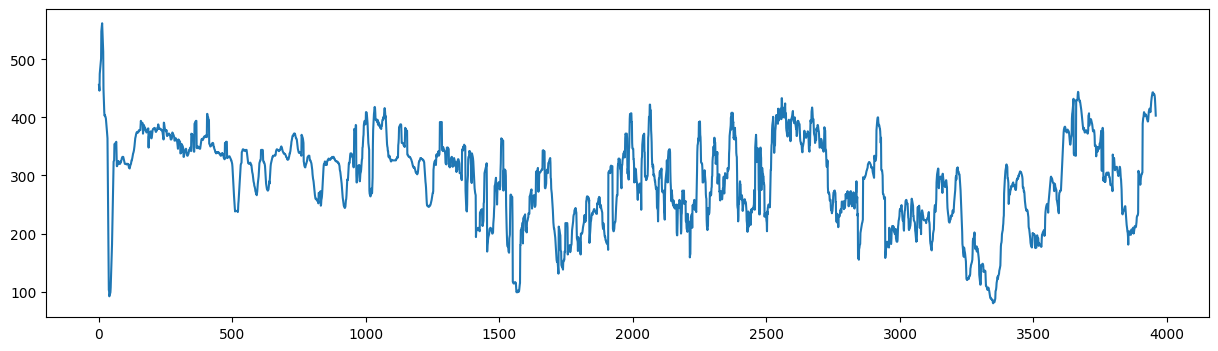

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

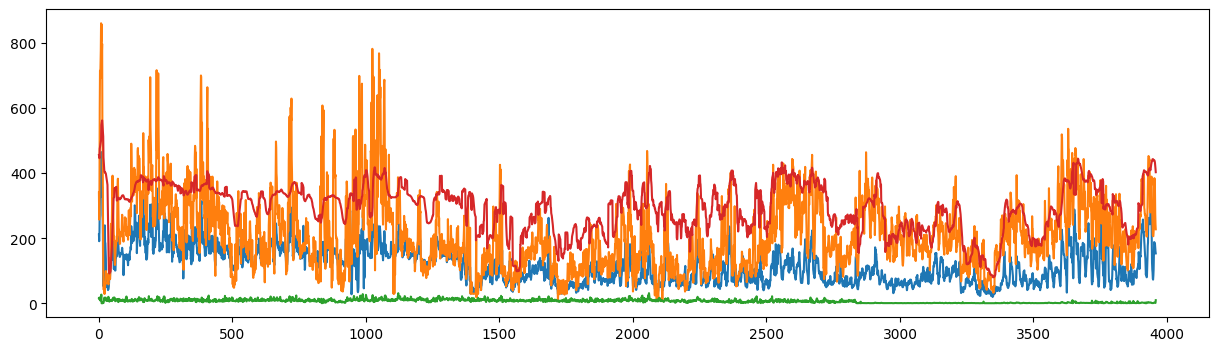

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3949, 10, 4])


tensor([1.7163, 1.1380, 1.5963, 2.1931])

In [17]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=4, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [19]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:151.68178814170096
[2/5]  LossQ:35.75520637621776
[3/5]  LossQ:28.474102065956686
[4/5]  LossQ:27.757963674277562
[5/5]  LossQ:27.292296103934405


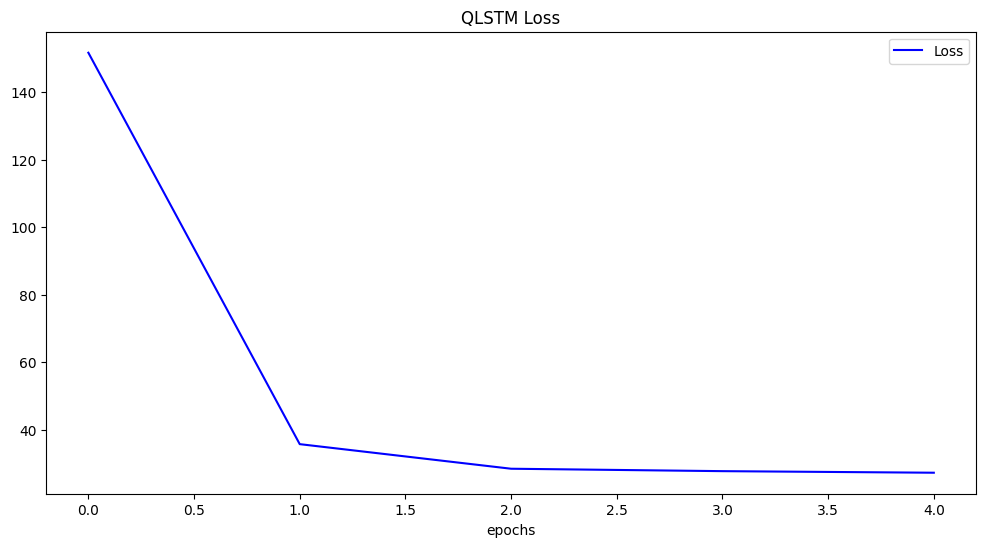

In [20]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [21]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [22]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([2.0861, 2.1995, 2.3072,  ..., 1.6630, 1.5749, 1.4837],
       grad_fn=<ViewBackward0>)


In [23]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [24]:
pred_y_train

tensor([[2.0861],
        [2.1995],
        [2.3072],
        ...,
        [1.6630],
        [1.5749],
        [1.4837]], grad_fn=<ViewBackward0>)

In [25]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:16.48262423362443


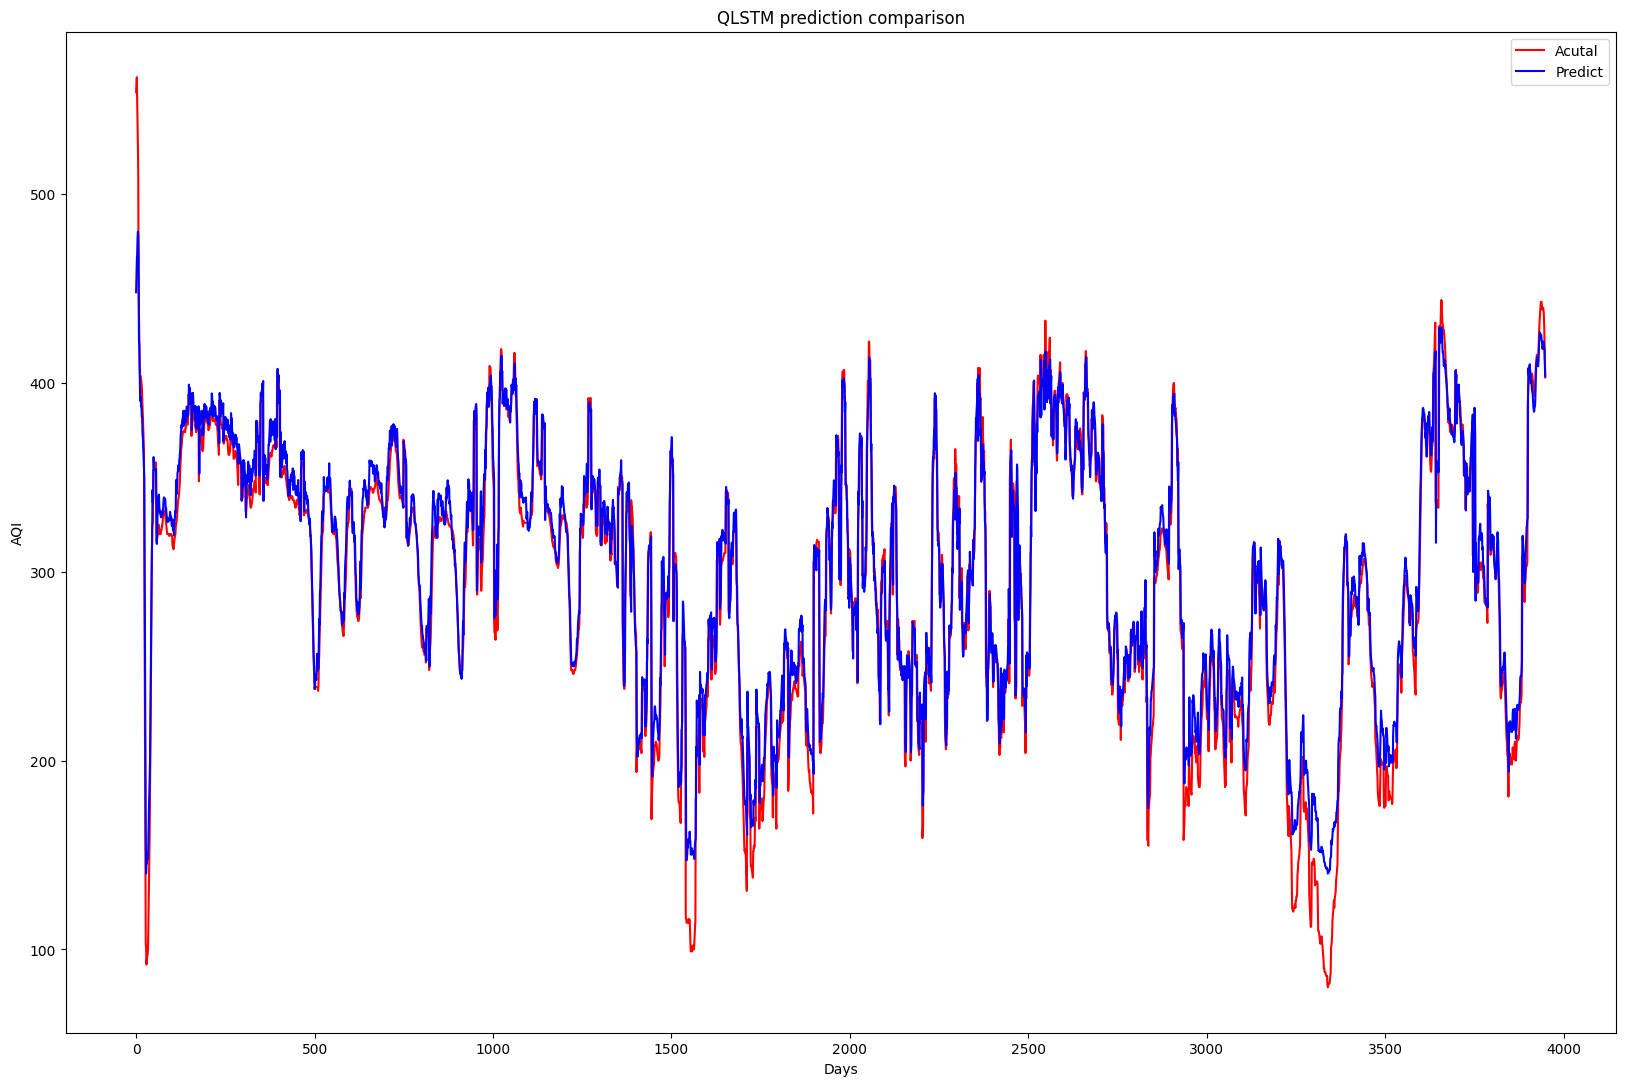

In [26]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:15.333468295067597


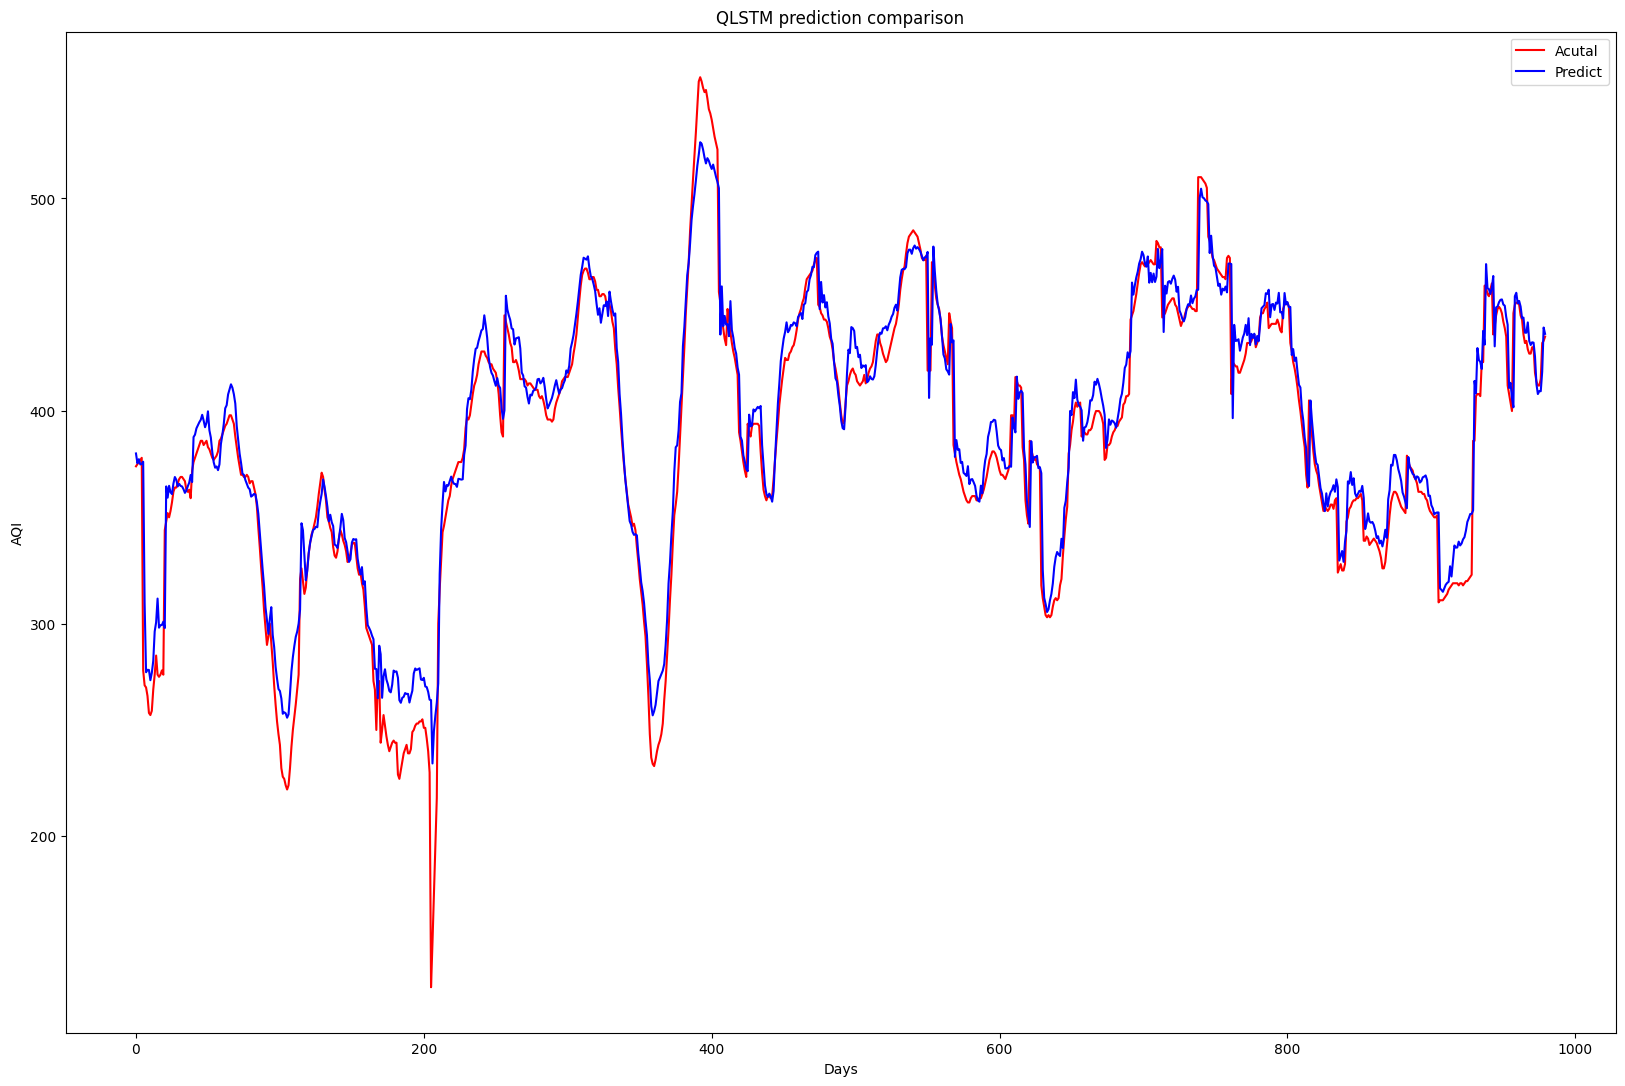

In [27]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')